In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import kurtosis,skew
from neurokit2.signal import signal_rate
from neurokit2.signal import signal_timefrequency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay

import bokeh
from bokeh.io import output_notebook
output_notebook()

import scipy
from scipy.signal import spectrogram
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

import neurokit2 as nk
import scipy.signal as signal
from importlib import reload

# import finalAnalytics as fa
import pathlib

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pickle

import os
import json
import datetime

Loading BokehJS ...

In [4]:
import utilities2 as ut

# Data Visualization

In [110]:
## import data

data = pd.read_csv('heel/heel_50ppm.csv')

## clean
data = data.drop(columns=['Activity', 'User', 'Trial Number'])
data = data.drop([0])
data['Arduino Time'] = data['Arduino Time'] - data.loc[1]['Arduino Time']

data.head()

,Time,Arduino Time,accel_X,accel_Y,accel_Z,gyro_X,gyro_Y,gyro_Z
1,52640.958,0.000000,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
2,52640.959,0.002014,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
3,52640.959,0.005005,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
4,52640.973,0.007019,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512
5,52640.974,0.020020,-9.456435,2.222932,0.988236,-0.085521,0.002443,0.107512


In [111]:
## filter

accel_X_filt = nk.signal_filter(data['accel_X'], sampling_rate = 30, lowcut = 6, method = "butterworth", order = 2)
accel_X_filt_h = nk.signal_filter(data['accel_X'], highcut = 100, method = "butterworth", order = 2)


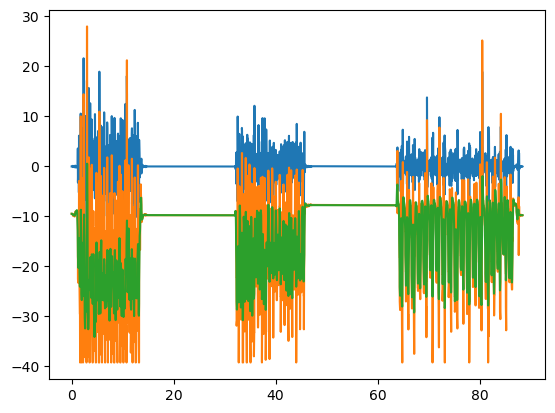

In [112]:
## plot

plt.plot(data['Arduino Time'],accel_X_filt)
plt.plot(data['Arduino Time'],data['accel_X'])
plt.plot(data['Arduino Time'],accel_X_filt_h)

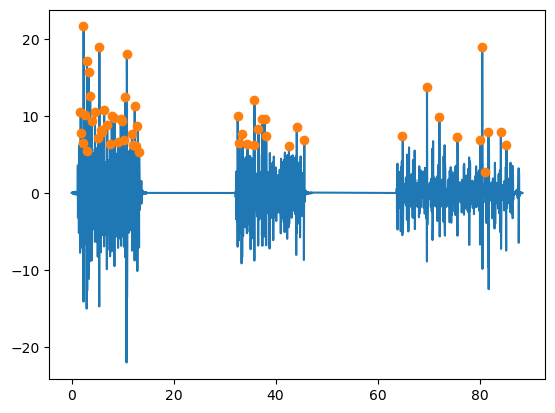

In [113]:
## peaks

peaks = nk.signal_findpeaks(accel_X_filt, height_min = 12)
pk_idx = peaks['Peaks']

plt.plot(data['Arduino Time'],accel_X_filt)
plt.plot(data['Arduino Time'][pk_idx],accel_X_filt[pk_idx],'o')

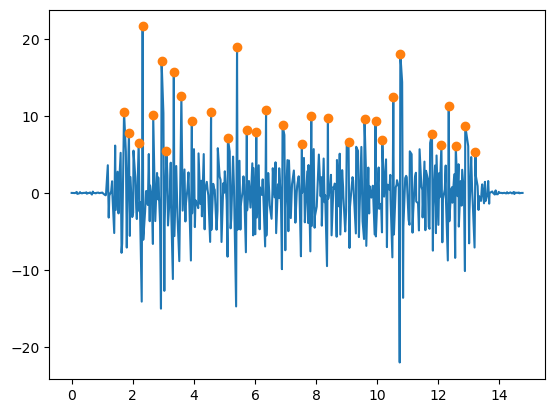

In [114]:
## cut data

cut = data[data['Arduino Time']<20].index.values
accel_X_filt_short = accel_X_filt[cut]
pk_idx_short = pk_idx[pk_idx < cut[-1]]

plt.plot(data['Arduino Time'][cut],accel_X_filt_short)
plt.plot(data['Arduino Time'][pk_idx_short],accel_X_filt[pk_idx_short],'o')


In [115]:
data['Arduino Time'][pk_idx_short]
# len(pk_idx_short)
# pk_idx_short

59      1.715027
63      1.875000
72      2.194000
76      2.324005
87      2.670013
94      2.944000
98      3.104004
105     3.344025
111     3.592010
120     3.934021
138     4.564026
154     5.114014
162     5.414001
171     5.734009
180     6.044006
189     6.364014
205     6.904022
223     7.536011
232     7.844025
246     8.389008
266     9.064026
282     9.587006
292     9.949005
299    10.169006
308    10.529022
315    10.759003
344    11.795013
353    12.104004
360    12.344025
367    12.574005
376    12.884003
384    13.219025
Name: Arduino Time, dtype: float64

In [54]:
path = '/Users/isabellagomez/Documents/Tesis/Classification_v2/heel_50ppm.csv'
df = ut.cleanRead(path)

left_x, right_x = ut.tightBounds(df,mode='mult',fat_avg = 15, prom=.2, peakFinding='scipy', int_size=0.8, step_size=0.05)

left_x

/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.81,
 1.61,
 2.8799999999999986,
 4.17,
 4.84,
 6.369999999999998,
 7.25,
 8.41,
 10.08,
 11.630000000000011,
 14.81000000000003,
 32.15999999999999,
 33.35999999999998,
 34.42,
 35.160000000000004,
 37.07999999999994,
 38.569999999999986,
 41.82999999999987,
 42.63,
 47.06999999999989,
 68.98999999999978,
 71.51,
 74.33999999999997,
 77.49999999999991,
 79.86999999999992,
 83.49999999999994)

In [121]:
## unified signal

mult = data['accel_X']*data['accel_Y']*data['accel_Z']*data['gyro_X']*data['gyro_Y']*data['gyro_Z']
dMult = np.gradient(mult)
ddMult = np.gradient(dMult)
prod = dMult * ddMult

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -7.51421908e-09, -1.48959927e-08,  1.47267047e-09])

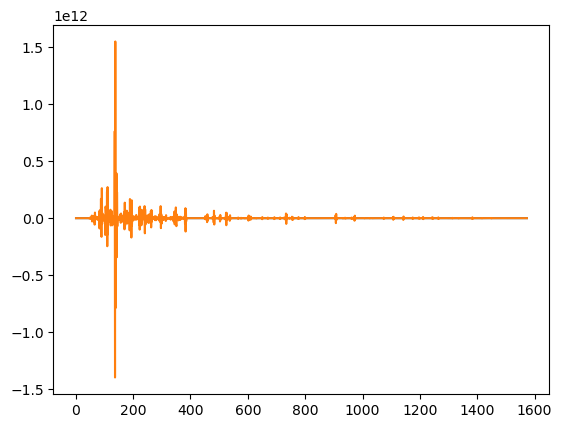

In [122]:
sig = {'Arduino Time':data['Arduino Time'],
       'signal':prod}
uni_sig = pd.DataFrame(sig)
plt.plot(uni_sig)

# Classification

In [6]:
classes = {"heel": 0, "stamp": 1, "toe": 2, "toe_rev": 3, "spin": 4}

# classes = {"heel": 0, "stamp": 1, "toe": 2, "toe_rev": 3}

### Read in files

In [7]:
files = pd.DataFrame()
csvList = [str(csv_file) for csv_file in pathlib.Path('./heel/').glob('**/*.csv')]
files['path'] = csvList
# GT = [classes[path.split('/')[2].split('_')[0]] for path in files.path.values]
GT = 0
files['GT'] = GT
files

,path,GT
0,heel/heel_80ppm.csv,0
1,heel/heel_100ppm.csv,0
2,heel/heel_50ppm.csv,0


In [8]:
csvList2 = [str(csv_file) for csv_file in pathlib.Path('./stamp/').glob('**/*.csv')]
GT = 1
stamps = {'path':csvList2,
          'GT':GT}
files = files.append(pd.DataFrame(stamps))
files

/var/folders/p7/fmncxg057zz07hpxfvt7jjb80000gn/T/ipykernel_69531/2279062645.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  files = files.append(pd.DataFrame(stamps))


,path,GT
0,heel/heel_80ppm.csv,0
1,heel/heel_100ppm.csv,0
2,heel/heel_50ppm.csv,0
0,stamp/stamp_50ppm.csv,1
1,stamp/stamp_100ppm.csv,1
2,stamp/stamp_80ppm.csv,1


In [9]:
csvList3 = [str(csv_file) for csv_file in pathlib.Path('./toe/').glob('**/*.csv')]
GT = 2
toes = {'path':csvList3,
          'GT':GT}
files = files.append(pd.DataFrame(toes))
files

/var/folders/p7/fmncxg057zz07hpxfvt7jjb80000gn/T/ipykernel_69531/4239526144.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  files = files.append(pd.DataFrame(toes))


,path,GT
0,heel/heel_80ppm.csv,0
1,heel/heel_100ppm.csv,0
2,heel/heel_50ppm.csv,0
0,stamp/stamp_50ppm.csv,1
1,stamp/stamp_100ppm.csv,1
2,stamp/stamp_80ppm.csv,1
0,toe/toe_80ppm.csv,2
1,toe/toe_50ppm.csv,2


In [10]:
csvList4 = [str(csv_file) for csv_file in pathlib.Path('./toe_rev/').glob('**/*.csv')]
GT = 3
toe_revs = {'path':csvList4,
          'GT':GT}
files = files.append(pd.DataFrame(toe_revs))
files

/var/folders/p7/fmncxg057zz07hpxfvt7jjb80000gn/T/ipykernel_69531/2016018656.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  files = files.append(pd.DataFrame(toe_revs))


,path,GT
0,heel/heel_80ppm.csv,0
1,heel/heel_100ppm.csv,0
2,heel/heel_50ppm.csv,0
0,stamp/stamp_50ppm.csv,1
1,stamp/stamp_100ppm.csv,1
2,stamp/stamp_80ppm.csv,1
0,toe/toe_80ppm.csv,2
1,toe/toe_50ppm.csv,2
0,toe_rev/toe_rev_80ppm.csv,3
1,toe_rev/toe_rev_1_100ppm.csv,3


In [11]:
csvList5 = [str(csv_file) for csv_file in pathlib.Path('./spin/').glob('**/*.csv')]
GT = 4
spins = {'path':csvList5,
          'GT':GT}
files = files.append(pd.DataFrame(spins))
files

/var/folders/p7/fmncxg057zz07hpxfvt7jjb80000gn/T/ipykernel_69531/1257080543.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  files = files.append(pd.DataFrame(spins))


,path,GT
0,heel/heel_80ppm.csv,0
1,heel/heel_100ppm.csv,0
2,heel/heel_50ppm.csv,0
0,stamp/stamp_50ppm.csv,1
1,stamp/stamp_100ppm.csv,1
2,stamp/stamp_80ppm.csv,1
0,toe/toe_80ppm.csv,2
1,toe/toe_50ppm.csv,2
0,toe_rev/toe_rev_80ppm.csv,3
1,toe_rev/toe_rev_1_100ppm.csv,3


In [12]:
def imuProcess_event(df, intervalTime = 1, stats = ['med_','std_','mean_'], mets = ['accel_X','accel_Y','accel_Z','gyro_X','gyro_Y', 'gyro_Z'], integrate = False, partial = 1):
    feature_names = []
    individualTrials = []
    GT = {'GT': []}
    for met in mets:
        for stat in stats:
            feature_names.append(stat+met)       
    
    #### File by file analysis ####
    for filepath, groundTruth in zip(df.path.values,df.GT.values):
        data = ut.cleanRead(filepath)
        time = data.Time.values
        try:
            reltime = time - time[0]
        except:
            print(filepath, time)
        data['Time'] = reltime
        try:
            pairs = ut.tightBounds(data,mode='mult',fat_avg = 15, prom=.2, peakFinding='scipy', int_size=intervalTime, step_size=0.05, separate_lr=False)
        except:
            print(filepath)
        for start, stop in pairs:
            stop = start + partial
            ds = {k: [] for k in feature_names}
            for met in mets:
                #FILTER
                thing = ut.filterBetween(data,met,start,stop)
                ds['med_' + met].append(np.median(thing))
                ds['std_'+ met].append(np.std(thing))
                ds['mean_'+ met].append(np.mean(thing))
            GT['GT'].append(groundTruth)
            subResult = pd.DataFrame(ds)
            individualTrials.append(subResult)
            
    result = pd.concat(individualTrials)
    result.reset_index(inplace=True, drop=True)
    return result, GT['GT']

In [14]:
X,y = imuProcess_event(files, partial = 0.5)
X

/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/

,med_accel_X,std_accel_X,mean_accel_X,med_accel_Y,std_accel_Y,mean_accel_Y,med_accel_Z,std_accel_Z,mean_accel_Z,med_gyro_X,std_gyro_X,mean_gyro_X,med_gyro_Y,std_gyro_Y,mean_gyro_Y,med_gyro_Z,std_gyro_Z,mean_gyro_Z
0,-18.589356,5.644183,-18.360656,3.791092,13.485787,5.680326,-3.917399,9.550611,0.524039,0.395418,1.343295,0.160289,1.941827,3.798115,1.206558,-1.502717,3.707862,-1.082716
1,-21.631257,11.455452,-18.237887,-0.141210,9.600558,4.160623,-5.276925,8.004746,-3.241533,0.343631,1.375721,0.337835,2.522438,4.040716,1.776817,-1.757775,4.338548,-1.249127
2,-20.789504,3.509623,-21.783415,6.056086,13.221611,6.764132,-3.682165,10.647841,-0.425210,-0.749816,1.560738,-0.639038,-1.369284,4.318041,-0.981562,0.924264,3.826410,0.545976
3,-21.342378,4.070366,-21.881864,5.794117,11.938694,7.963572,-3.832678,10.114551,-0.405992,0.481527,1.703666,0.085231,2.375461,4.251526,1.493333,-1.498733,4.231289,-0.935107
4,-23.051448,2.717468,-23.149284,-3.798000,12.784868,4.891014,-8.217212,10.073802,-1.759724,0.638027,1.263229,0.519316,2.071854,3.957953,1.403500,-1.889081,3.669662,-1.391483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,-11.977592,1.760209,-11.366050,1.559928,0.945785,1.262302,-2.416430,2.048550,-2.909265,-2.735766,2.077274,-2.761924,-2.401512,0.656112,-2.146953,-0.707202,0.833583,-0.337787
844,-11.902066,2.441865,-12.302274,0.834816,1.054041,0.978232,-1.123263,1.639093,-2.029254,-0.736701,2.987437,-2.307124,-1.473198,1.217634,-1.550835,-0.819890,0.387688,-0.751664
845,-8.518232,1.647553,-8.560005,-0.108662,0.693050,-0.136186,-6.175107,1.035707,-5.776458,-4.444058,0.890882,-4.566293,-2.250581,0.370417,-2.163742,0.541794,1.122205,0.665598
846,-9.559246,2.089588,-9.666342,0.890081,0.429166,1.048465,-6.561198,1.602772,-5.910737,-4.440425,1.218716,-4.100274,-2.331966,0.572715,-2.150062,0.704299,1.673431,0.871884


In [15]:
drops = X[X.isna().any(axis=1)]
# drops
X = X.drop(drops.index, axis = 0)
# X = X.reset_index(drop = True)
X = X.reset_index(drop = True)
X

,med_accel_X,std_accel_X,mean_accel_X,med_accel_Y,std_accel_Y,mean_accel_Y,med_accel_Z,std_accel_Z,mean_accel_Z,med_gyro_X,std_gyro_X,mean_gyro_X,med_gyro_Y,std_gyro_Y,mean_gyro_Y,med_gyro_Z,std_gyro_Z,mean_gyro_Z
0,-18.589356,5.644183,-18.360656,3.791092,13.485787,5.680326,-3.917399,9.550611,0.524039,0.395418,1.343295,0.160289,1.941827,3.798115,1.206558,-1.502717,3.707862,-1.082716
1,-21.631257,11.455452,-18.237887,-0.141210,9.600558,4.160623,-5.276925,8.004746,-3.241533,0.343631,1.375721,0.337835,2.522438,4.040716,1.776817,-1.757775,4.338548,-1.249127
2,-20.789504,3.509623,-21.783415,6.056086,13.221611,6.764132,-3.682165,10.647841,-0.425210,-0.749816,1.560738,-0.639038,-1.369284,4.318041,-0.981562,0.924264,3.826410,0.545976
3,-21.342378,4.070366,-21.881864,5.794117,11.938694,7.963572,-3.832678,10.114551,-0.405992,0.481527,1.703666,0.085231,2.375461,4.251526,1.493333,-1.498733,4.231289,-0.935107
4,-23.051448,2.717468,-23.149284,-3.798000,12.784868,4.891014,-8.217212,10.073802,-1.759724,0.638027,1.263229,0.519316,2.071854,3.957953,1.403500,-1.889081,3.669662,-1.391483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,-11.977592,1.760209,-11.366050,1.559928,0.945785,1.262302,-2.416430,2.048550,-2.909265,-2.735766,2.077274,-2.761924,-2.401512,0.656112,-2.146953,-0.707202,0.833583,-0.337787
825,-11.902066,2.441865,-12.302274,0.834816,1.054041,0.978232,-1.123263,1.639093,-2.029254,-0.736701,2.987437,-2.307124,-1.473198,1.217634,-1.550835,-0.819890,0.387688,-0.751664
826,-8.518232,1.647553,-8.560005,-0.108662,0.693050,-0.136186,-6.175107,1.035707,-5.776458,-4.444058,0.890882,-4.566293,-2.250581,0.370417,-2.163742,0.541794,1.122205,0.665598
827,-9.559246,2.089588,-9.666342,0.890081,0.429166,1.048465,-6.561198,1.602772,-5.910737,-4.440425,1.218716,-4.100274,-2.331966,0.572715,-2.150062,0.704299,1.673431,0.871884


In [16]:
for idx in range(len(drops.index)-1):
    y.pop(drops.index[idx])


In [17]:
y.pop()

4

### Split Data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 12)

## KNN

              precision    recall  f1-score   support

           0       0.47      0.40      0.43        40
           1       0.71      0.64      0.67        45
           2       0.45      0.53      0.49        38
           3       0.37      0.55      0.44        20
           4       1.00      0.98      0.99       272

    accuracy                           0.82       415
   macro avg       0.60      0.62      0.60       415
weighted avg       0.84      0.82      0.83       415



/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


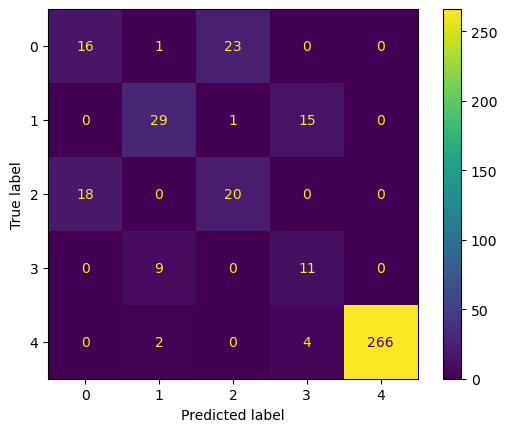

In [20]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test.values)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3, 4])
disp.plot()

print(classification_report(y_test, y_pred))

## Random Forest

              precision    recall  f1-score   support

           0       0.40      0.30      0.34        40
           1       0.76      0.76      0.76        45
           2       0.41      0.53      0.46        38
           3       0.47      0.45      0.46        20
           4       0.99      0.99      0.99       272

    accuracy                           0.83       415
   macro avg       0.61      0.60      0.60       415
weighted avg       0.83      0.83      0.83       415



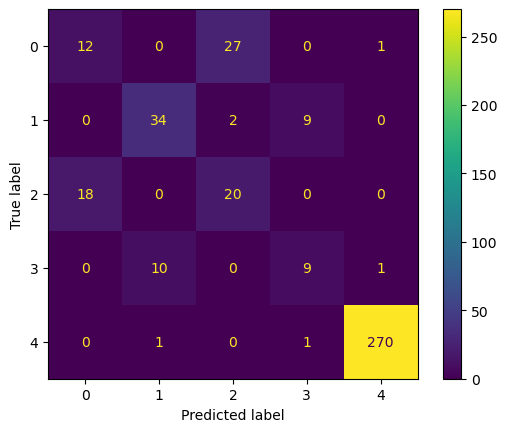

In [21]:
scaler = StandardScaler()
s = scaler.fit(X_train)
X_train = s.transform(X_train)
X_test = s.transform(X_test)

rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Model Evaluation
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4])
disp.plot()

print(classification_report(y_test, y_pred))

### Save Models

In [22]:
filename_rf = 'randomForestModel_ES.pickle'
filename_knn = 'knnModel_ES.pickle'
filename_s = 'scaler_ES.pickle'

# save models
pickle.dump(rf, open(filename_rf, "wb"))
pickle.dump(knn, open(filename_knn, "wb"))

# save scaler
pickle.dump(s, open(filename_s, "wb"))

# ArtLab Data

In [150]:
classes = {"jumps": 0, "lat_jump": 1, "lats": 2, "stamps": 3, "spin": 4}

In [154]:
files = pd.DataFrame()
csvList = [str(csv_file) for csv_file in pathlib.Path('./artlab/jumps/').glob('**/*.csv')]
files['path'] = csvList
# GT = [classes[path.split('/')[2].split('_')[0]] for path in files.path.values]
GT = 0
files['GT'] = GT
files

,path,GT
0,artlab/jumps/jump2.csv,0
1,artlab/jumps/jump1.csv,0


In [155]:
csvList2 = [str(csv_file) for csv_file in pathlib.Path('./artlab/lat_jump/').glob('**/*.csv')]
GT = 1
lat_jumps = {'path':csvList2,
          'GT':GT}
files = files.append(pd.DataFrame(lat_jumps))
files

/var/folders/p7/fmncxg057zz07hpxfvt7jjb80000gn/T/ipykernel_1961/2964210252.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  files = files.append(pd.DataFrame(lat_jumps))


,path,GT
0,artlab/jumps/jump2.csv,0
1,artlab/jumps/jump1.csv,0
0,artlab/lat_jump/jumps1.csv,1


In [156]:
csvList3 = [str(csv_file) for csv_file in pathlib.Path('./artlab/lats/').glob('**/*.csv')]
GT = 2
lats = {'path':csvList3,
          'GT':GT}
files = files.append(pd.DataFrame(lats))
files

/var/folders/p7/fmncxg057zz07hpxfvt7jjb80000gn/T/ipykernel_1961/1709504761.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  files = files.append(pd.DataFrame(lats))


,path,GT
0,artlab/jumps/jump2.csv,0
1,artlab/jumps/jump1.csv,0
0,artlab/lat_jump/jumps1.csv,1
0,artlab/lats/lat2.csv,2
1,artlab/lats/lat1.csv,2


In [157]:
csvList4 = [str(csv_file) for csv_file in pathlib.Path('./artlab/stamps/').glob('**/*.csv')]
GT = 3
stamps = {'path':csvList4,
          'GT':GT}
files = files.append(pd.DataFrame(stamps))
files

/var/folders/p7/fmncxg057zz07hpxfvt7jjb80000gn/T/ipykernel_1961/3342421349.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  files = files.append(pd.DataFrame(stamps))


,path,GT
0,artlab/jumps/jump2.csv,0
1,artlab/jumps/jump1.csv,0
0,artlab/lat_jump/jumps1.csv,1
0,artlab/lats/lat2.csv,2
1,artlab/lats/lat1.csv,2
0,artlab/stamps/stamp1.csv,3
1,artlab/stamps/stamp2.csv,3


In [158]:
csvList5 = [str(csv_file) for csv_file in pathlib.Path('./spin/').glob('**/*.csv')]
GT = 4
spins = {'path':csvList5,
          'GT':GT}
files = files.append(pd.DataFrame(spins))
files

/var/folders/p7/fmncxg057zz07hpxfvt7jjb80000gn/T/ipykernel_1961/1257080543.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  files = files.append(pd.DataFrame(spins))


,path,GT
0,artlab/jumps/jump2.csv,0
1,artlab/jumps/jump1.csv,0
0,artlab/lat_jump/jumps1.csv,1
0,artlab/lats/lat2.csv,2
1,artlab/lats/lat1.csv,2
0,artlab/stamps/stamp1.csv,3
1,artlab/stamps/stamp2.csv,3
0,spin/spin1.csv,4
1,spin/spin_krithika_25_2.csv,4
2,spin/spin_krithika_25_1.csv,4


In [159]:
X,y = ut.imuProcess_event(files, partial = 0.5)
X

,med_accel_X,std_accel_X,mean_accel_X,med_accel_Y,std_accel_Y,mean_accel_Y,med_accel_Z,std_accel_Z,mean_accel_Z,med_gyro_X,std_gyro_X,mean_gyro_X,med_gyro_Y,std_gyro_Y,mean_gyro_Y,med_gyro_Z,std_gyro_Z,mean_gyro_Z
0,9.498384,1.035858,9.939715,4.245794,2.010436,3.639051,-2.731476,0.656811,-2.468185,-0.096058,0.184139,-0.002442,-0.016637,0.269274,-0.098319,0.082906,0.181667,0.036705
1,2.074785,12.802788,4.763066,-0.713506,2.463849,-0.004202,-2.895822,2.306958,-2.111293,-0.119575,0.424458,-0.138212,-0.142808,0.342559,-0.234795,0.324388,0.433482,0.416879
2,3.768609,9.350330,1.673418,-0.341517,5.074865,-1.096711,-3.490864,3.985641,-2.824232,-0.856673,1.229538,-0.189885,-0.408008,0.199685,-0.370760,0.012075,0.908093,0.007255
3,6.889112,5.168635,5.819863,4.680405,4.930120,3.431637,-2.267514,3.827461,-2.093616,0.452411,0.367916,0.479725,-0.369387,0.227964,-0.309564,-0.198190,0.242528,-0.179971
4,10.317566,2.748595,10.740822,4.747808,2.852089,5.008949,-3.977693,1.187050,-4.009665,0.579389,0.701474,0.685523,0.146376,0.189198,0.141524,0.033524,0.126416,0.032059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,-11.977592,1.760209,-11.366050,1.559928,0.945785,1.262302,-2.416430,2.048550,-2.909265,-2.735766,2.077274,-2.761924,-2.401512,0.656112,-2.146953,-0.707202,0.833583,-0.337787
622,-11.902066,2.441865,-12.302274,0.834816,1.054041,0.978232,-1.123263,1.639093,-2.029254,-0.736701,2.987437,-2.307124,-1.473198,1.217634,-1.550835,-0.819890,0.387688,-0.751664
623,-8.518232,1.647553,-8.560005,-0.108662,0.693050,-0.136186,-6.175107,1.035707,-5.776458,-4.444058,0.890882,-4.566293,-2.250581,0.370417,-2.163742,0.541794,1.122205,0.665598
624,-9.559246,2.089588,-9.666342,0.890081,0.429166,1.048465,-6.561198,1.602772,-5.910737,-4.440425,1.218716,-4.100274,-2.331966,0.572715,-2.150062,0.704299,1.673431,0.871884


## Classifiers

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 12)

### KNN

              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.33      0.25      0.29         4
           2       0.69      0.85      0.76        13
           3       0.67      0.84      0.74        19
           4       1.00      0.99      0.99       270

    accuracy                           0.95       313
   macro avg       0.67      0.64      0.64       313
weighted avg       0.95      0.95      0.95       313



/Users/isabellagomez/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


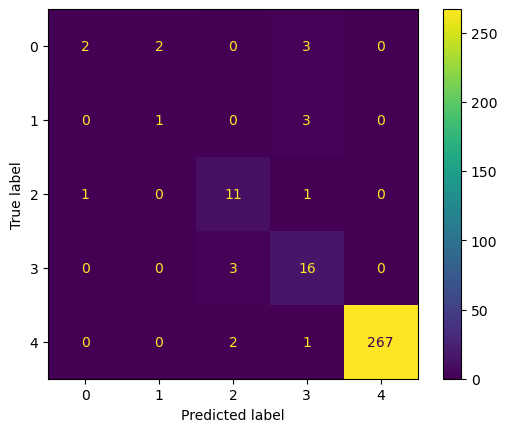

In [162]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test.values)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4])
disp.plot()

print(classification_report(y_test, y_pred))

### Random Forest

              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.00      0.00      0.00         4
           2       0.50      0.92      0.65        13
           3       0.71      0.63      0.67        19
           4       1.00      0.99      0.99       270

    accuracy                           0.94       313
   macro avg       0.64      0.59      0.58       313
weighted avg       0.95      0.94      0.94       313



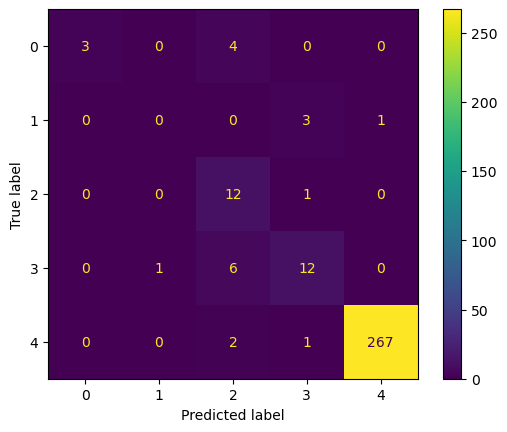

In [165]:
scaler = StandardScaler()
s = scaler.fit(X_train)
X_train = s.transform(X_train)
X_test = s.transform(X_test)

rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Model Evaluation
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3,4])
disp.plot()

print(classification_report(y_test, y_pred))